In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
from collections import Counter, namedtuple
import re
import markov_clustering as mc
import networkx as nx
import numpy as np

In [122]:
data = []

clusters = {}
with open('../data/seqs/unknown_nterm_clustered_70.fa.clstr') as infile:
    for line in infile:
        hits = re.search(f'>(.+?)(($)|(\.\.\.))', line)
        if not hits:
            continue
        if hits.group(1).startswith('Cluster'):
            cluster = hits.group(1)
        else:
            clusters[hits.group(1)] = cluster


for record in SeqIO.parse('../data/seqs/unknown_nterm.fa', 'fasta'):
    species = re.search('\[(.+)?\]', record.description).group(1)
    seqlen = len(record.seq)
    data.append([species, seqlen, f'{record.name}', clusters.get(record.id, np.nan)])
df = pd.DataFrame(data, columns=['species', 'seqlen', 'name', 'cluster']).dropna().sort_values('cluster')
print(df.head())
print(df.size)

                      species  seqlen                  name    cluster
93048      Oxyura jamaicensis     277  XP_035192477.1_nterm  Cluster 0
36570    Dasypus novemcinctus     266  XP_004459738.1_nterm  Cluster 0
29060           Columba livia     284  XP_005512673.1_nterm  Cluster 0
99214     Peromyscus leucopus     266  XP_028710217.1_nterm  Cluster 0
114574  Rousettus aegyptiacus     271  XP_016019269.1_nterm  Cluster 0
517372


In [123]:
def species_diversity(df):
    nseqs = len(df)
    nspecies = len(set(df.species))
    return nspecies/nseqs

cluster_df = df.groupby('cluster').apply(species_diversity).sort_values().reset_index()
print(cluster_df)

             cluster         0
0         Cluster 78  0.008850
1          Cluster 8  0.009009
2        Cluster 197  0.016949
3        Cluster 200  0.016949
4        Cluster 228  0.019231
...              ...       ...
45720  Cluster 25145  1.000000
45721  Cluster 25146  1.000000
45722  Cluster 25147  1.000000
45723  Cluster 25149  1.000000
45724   Cluster 9999  1.000000

[45725 rows x 2 columns]


In [124]:
for row in cluster_df.head(20).iterrows():
    print(row[1].cluster, f'{row[1][0]:.3f}')
    print(Counter(df.loc[df.cluster == row[1].cluster, 'species']))
    print(df.loc[df.cluster == row[1].cluster, 'seqlen'].describe())
    print()

Cluster 78 0.009
Counter({'Danio rerio': 113})
count    113.000000
mean      73.920354
std       12.212509
min       31.000000
25%       73.000000
50%       77.000000
75%       82.000000
max      105.000000
Name: seqlen, dtype: float64

Cluster 8 0.009
Counter({'Astyanax mexicanus': 221, 'Stegodyphus dumicola': 1})
count    222.000000
mean      14.936937
std        6.933791
min       12.000000
25%       14.000000
50%       14.000000
75%       14.000000
max      105.000000
Name: seqlen, dtype: float64

Cluster 197 0.017
Counter({'Acanthochromis polyacanthus': 59})
count    59.000000
mean     36.847458
std       4.381834
min      36.000000
25%      36.000000
50%      36.000000
75%      36.000000
max      60.000000
Name: seqlen, dtype: float64

Cluster 200 0.017
Counter({'Rana temporaria': 59})
count     59.000000
mean      95.966102
std       43.647872
min       54.000000
25%       70.000000
50%       70.000000
75%      112.000000
max      268.000000
Name: seqlen, dtype: float64

Cluster

In [125]:
clust_df = df.groupby('cluster')[['name']].count().sort_values('name').reset_index()
for c in clust_df.tail(10)['cluster']:
    print(f'CLUSTER {c}')
    print(df.loc[df.cluster == c].groupby('species')['name'].count().sort_values())
    print()
# print(df.loc[df.species.str.contains('Cypr')].groupby('cluster')['species'].count().sort_values())

CLUSTER Cluster 9
species
Acinonyx jubatus               1
Ochotona curzoniae             1
Ochotona princeps              1
Octodon degus                  1
Odobenus rosmarus divergens    1
                              ..
Gracilinanus agilis            1
Erinaceus europaeus            1
Zalophus californianus         1
Polyodon spathula              2
Xenopus laevis                 2
Name: name, Length: 203, dtype: int64

CLUSTER Cluster 8
species
Stegodyphus dumicola      1
Astyanax mexicanus      221
Name: name, dtype: int64

CLUSTER Cluster 7
species
Acinonyx jubatus               1
Ochotona curzoniae             1
Ochotona princeps              1
Octodon degus                  1
Odobenus rosmarus divergens    1
                              ..
Gorilla gorilla gorilla        1
Grammomys surdaster            1
Gymnogyps californianus        1
Falco cherrug                  1
Zootoca vivipara               1
Name: name, Length: 233, dtype: int64

CLUSTER Cluster 6
species
Accipiter 

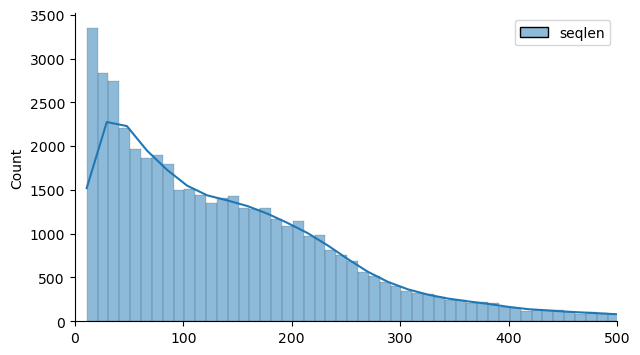

In [127]:
fig, ax = plt.subplots(figsize=(7, 4))
# sns.histplot(df.loc[df.species == 'Octopus bimaculoides', 'seqlen'], ax=ax, kde=True, log_scale=False, binwidth=10)
sns.histplot(df.groupby('cluster')[['seqlen']].median(), ax=ax, kde=True, log_scale=False, binwidth=10)
ax.set_xlim(0, 500)
sns.despine()
plt.show()

In [128]:
# for i in range(20, 40):
    # print(i)
print(df.loc[(df.seqlen >= 25) & (df.seqlen <= 35)].groupby('species')['name'].count().sort_values().tail(5))
    # print()

species
Branchiostoma floridae     84
Eriocheir sinensis        109
Astyanax mexicanus        146
Octopus sinensis          273
Octopus bimaculoides      285
Name: name, dtype: int64


In [130]:
def extract_kmers(seqfile, k=4):
    kmers = Counter()
    for record in SeqIO.parse(seqfile, 'fasta'):
        seq = list(str(record.seq))
        # for i in range(len(seq)-k):
        for i in range(40):
            kmer = ''.join(seq[i:i+k])
            if len(kmer) != k:
                continue
            kmers[kmer] += 1
    return kmers

nterm_kmers = extract_kmers('../data/seqs/unknown_nterm_clustered_70.fa')
cterm_kmers = extract_kmers('../data/seqs/unknown_cterm.fa')
sprot_kmers = extract_kmers('/Users/jonwells/Genomes/Uniprot/uniprot_sprot.fasta')

data = []
for key in set(nterm_kmers.keys()).intersection(cterm_kmers.keys(), sprot_kmers.keys()):
    data.append([key, nterm_kmers.get(key, 0), cterm_kmers.get(key, 0), sprot_kmers.get(key, 0)])
df = pd.DataFrame(data, columns=['kmer', 'nterm', 'cterm', 'sprot'] ) \
       .sort_values('nterm') \
       .reset_index(drop=True)


In [140]:
df['sumoylation'] = df['kmer'].apply(lambda x: bool(re.search('[VILMAFP](K).E', x)))
df['sumoylation'] = df['kmer'].apply(lambda x: bool(re.search('IKEE', x)))
df = df.loc[~df.kmer.str.contains('X')]
print(df.tail(20))

        kmer  nterm  cterm  sprot  sumoylation
128767  RRKQ    573     66    219        False
128768  EEEI    603    137    601        False
128769  SSSS    628   2999   5669        False
128770  IKQE    667    140    172        False
128771  EESE    691    436    335        False
128772  AAAA    780   6544   8494        False
128773  EEIF    781     14    224        False
128774  QQQQ    787   6313   2691        False
128775  YEEE    794    171    186        False
128776  RLTA    808     38    668        False
128777  KEES    821    156    246        False
128778  TAAA    825    576   2029        False
128779  AEEI    834     43    765        False
128780  LTAA    838     94   2019        False
128781  AAEE    881    478    901        False
128782  AAAE    936    614   1590        False
128783  KEEE    981    284    643        False
128784  VKEE   1504    925    441        False
128785  EEEE   1864   4014   2199        False
128786  IKEE   2321    232    462         True


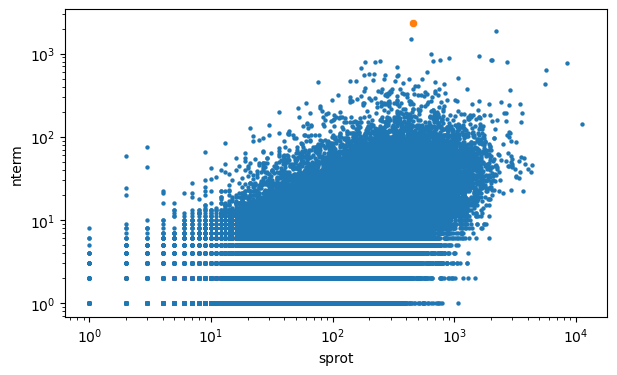

In [141]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(data=df.loc[df.sumoylation == False], x='sprot', y='nterm', linewidth=0, s=10)
sns.scatterplot(data=df.loc[df.sumoylation == True], x='sprot', y='nterm')
ax.set_xscale('log')
ax.set_yscale('log')

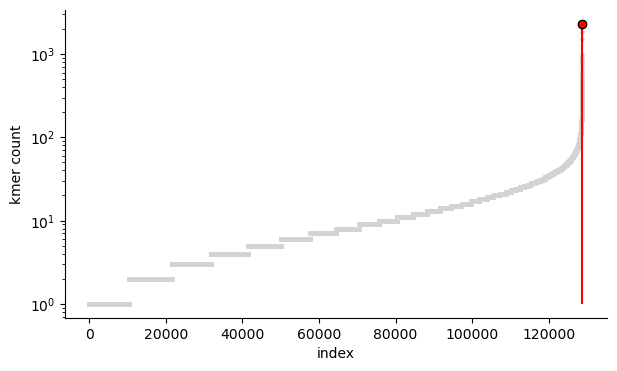

In [148]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.scatterplot(data=df, 
                y='nterm', 
                x=df.index, 
                ax=ax, 
                linewidth=0, 
                s=10,
                color='lightgrey')
markerline, stemlines, baseline = plt.stem(list(df.loc[df.sumoylation == True].index), 
                                           df.loc[df.sumoylation == True, 'nterm'], 
                                           linefmt='red',
                                           bottom=1)
baseline.remove()
markerline.set_markerfacecolor('red')
markerline.set_markeredgecolor('k')


ax.set_ylabel('kmer count')
ax.set_xlabel('index')
ax.set_yscale('log')
sns.despine()
plt.show()
fig.savefig('/Users/jonwells/Desktop/test.png')